# Business Analysis With Python

We will be using the [Chinook](https://github.com/lerocha/chinook-database#:~:text=Chinook%20is%20a%20sample%20database,single%20and%20multiple%20database%20servers.) database for this project. It is a sample/demo database that represents a digital media store. It is partially based on the iTunes Library. Below is a diagram of the databases' tables and connections:

In [51]:
%%capture
%load_ext sql
%sql sqlite:///chinook.db

# 1.0 Exploring the Database

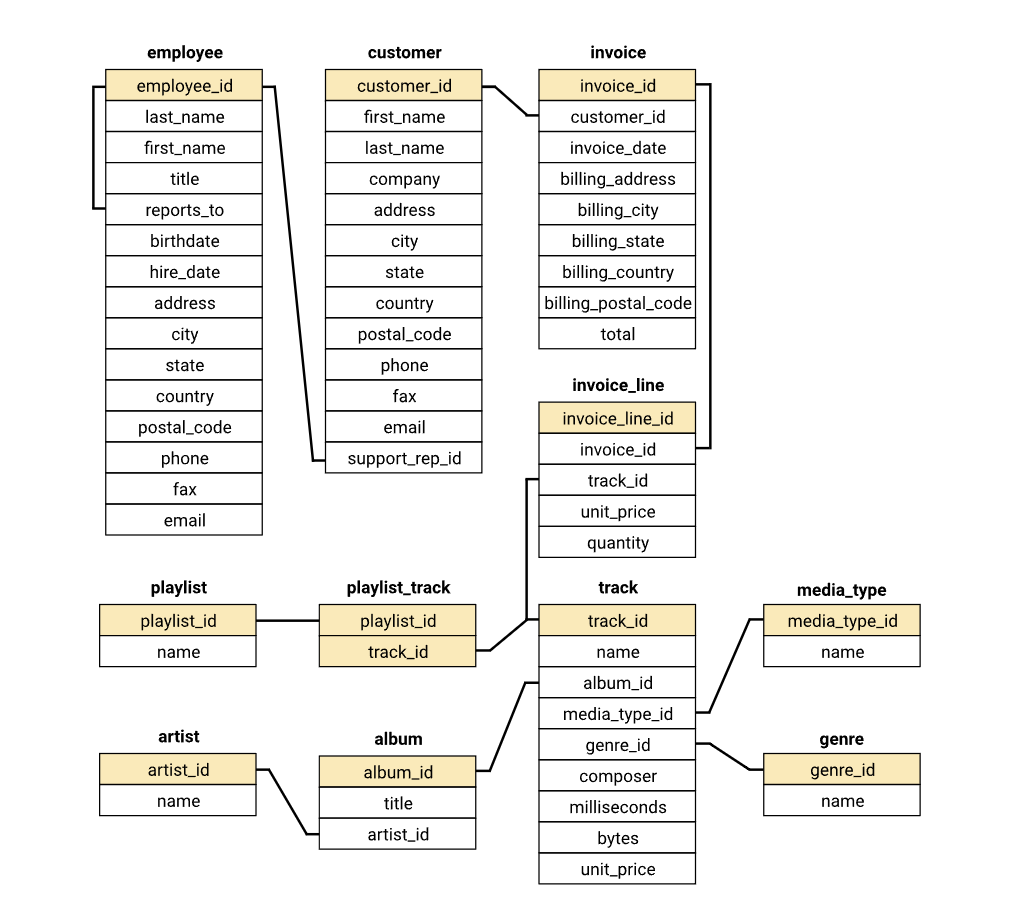

In [52]:
from IPython import display
display.Image("./chinook.png")

In [53]:
%%sql
SELECT
      name,
      type
  FROM sqlite_master
 WHERE type IN ("table", "view");

 * sqlite:///chinook.db
Done.


name,type
album,table
artist,table
customer,table
employee,table
genre,table
invoice,table
invoice_line,table
media_type,table
playlist,table
playlist_track,table


# 2.0 Analyzing the Data

## 2.1 Choosing Artists to Market Based on Genre Popularity

Chinook has signed a new deal with a record label that specializes in the US market. We need to pick the three first albums, from a list of four, from the record label that should be added to our store. Since the label specializes in the US we will find out which genres sell the most tracks in that market.

These are the artists we can choose from:
| Artist Name          | Genre   |
|----------------------|---------|
| Regal                | Hip-Hop |
| Red Tone             | Punk    |
| Meteor and the Girls | Pop     |
| Slim Jim Bites       | Blues   |

In [54]:
%%sql
/* creating query that returns number of tracks sold in the US for each genre */
WITH
     tracks_sold_us AS
                      (
                       SELECT
                             g.name,
                             SUM(il.quantity) AS tracks_sold,
                             i.billing_country
                         FROM invoice_line AS il
                       INNER JOIN invoice AS i ON il.invoice_id = i.invoice_id
                       INNER JOIN track AS t ON il.track_id = t.track_id
                       INNER JOIN genre AS g ON t.genre_id = g.genre_id
                        WHERE i.billing_country = 'USA'
                        GROUP BY g.name
                        ORDER BY tracks_sold DESC
                      ),
     total_sold_us AS
                     (
                      SELECT SUM(tracks_sold) AS total_sold_us
                        FROM tracks_sold_us
                     )

SELECT 
      tsu.name,
      tsu.tracks_sold,
      ROUND (tsu.tracks_sold / (
                                SELECT CAST(SUM(tracks_sold) AS FLOAT) AS total_sold_us
                                  FROM tracks_sold_us
                               ),2) AS percent_of_total_us_sale,
      tsu.billing_country
  FROM tracks_sold_us AS tsu
      


 * sqlite:///chinook.db
Done.


name,tracks_sold,percent_of_total_us_sale,billing_country
Rock,561,0.53,USA
Alternative & Punk,130,0.12,USA
Metal,124,0.12,USA
R&B/Soul,53,0.05,USA
Blues,36,0.03,USA
Alternative,35,0.03,USA
Pop,22,0.02,USA
Latin,22,0.02,USA
Hip Hop/Rap,20,0.02,USA
Jazz,14,0.01,USA


Based on the above results we should choose `Red Tone`, `Slim Jim Bites` and `Meteor and the Girls`, in that order.

## 2.2 Sales Support Agent Performance

Every customer gets assigned a sales support agent when they make their first purchase. We will analyze the performance of each agent based on the purchases of their customers.

In [76]:
%%sql
SELECT
      (e.first_name || " " || e.last_name) AS 'employee_name',
      e.title AS employee_title,
      e.hire_date,
      ROUND(SUM(i.total),2) AS total_sales
  FROM employee AS e
INNER JOIN customer AS c ON e.employee_id = c.support_rep_id
INNER JOIN invoice AS i ON c.customer_id = i.customer_id
 WHERE e.title = 'Sales Support Agent'
 GROUP BY employee_id 

 * sqlite:///chinook.db
Done.


employee_name,employee_title,hire_date,total_sales
Jane Peacock,Sales Support Agent,2017-04-01 00:00:00,1731.51
Margaret Park,Sales Support Agent,2017-05-03 00:00:00,1584.0
Steve Johnson,Sales Support Agent,2017-10-17 00:00:00,1393.92


The employees have total sales that roughly matches up with their hiring dates. They seem to be doing about equally well in terms of earnings per month.

## 2.3 Sales by Country

We will analyze sales data based on the customers listed country, using the `country` column in the `customer` table. We will not use the `billing_country` column like we did previously.  
We will calculate the following for each country:
- total number of customers
- total value of sales
- average value of sales per customer
- average order (invoice) value

All countries that have only one customer will be grouped together as `other`.

In [75]:
%%sql
WITH other AS 
                      (
                       SELECT
                         CASE
                             WHEN (
                                   SELECT COUNT(*)
                                     FROM customer
                                    WHERE country = c.country
                                  ) = 1 THEN "Other"
                             ELSE c.country
                          END AS country,  
                          c.customer_id,
                          il.*
                         FROM invoice_line AS il
                        INNER JOIN invoice AS i ON i.invoice_id = il.invoice_id 
                        INNER JOIN customer AS c ON c.customer_id = i.customer_id
                        GROUP BY i.customer_id
                      )

SELECT
      o.country,
      COUNT(DISTINCT(c.customer_id)) AS total_customers,
      ROUND(SUM(i.total),2) AS total_purchase,
      ROUND(AVG(i.total),2) AS avg_order_value,
      ROUND(SUM(i.total) / COUNT(DISTINCT i.customer_id),2) lifetime_purchases,
      CASE
          WHEN o.country = 'Other' THEN 1
          ELSE 0
      END AS sort
  FROM customer AS c
INNER JOIN invoice AS i ON c.customer_id = i.customer_id
INNER JOIN other AS o ON c.customer_id = o.customer_id
 GROUP BY o.country
 ORDER BY sort ASC, total_purchase DESC


 * sqlite:///chinook.db
Done.


country,total_customers,total_purchase,avg_order_value,lifetime_purchases,sort
USA,13,1040.49,7.94,80.04,0
Canada,8,535.59,7.05,66.95,0
Brazil,5,427.68,7.01,85.54,0
France,5,389.07,7.78,77.81,0
Germany,4,334.62,8.16,83.66,0
Czech Republic,2,273.24,9.11,136.62,0
United Kingdom,3,245.52,8.77,81.84,0
Portugal,2,185.13,6.38,92.57,0
India,2,183.15,8.72,91.57,0
Other,15,1094.94,7.45,73.0,1


The Czech Republic, United Kingdom, Portugal And India all look promising. The sales in these countries could likely be improved further.  
There is to little data in the dataset to say for sure. The best approach would be to run limited advertising in these markets to test the response. 

## 2.4 Sales of Tracks & Albums

The Chinook store allows purchase of individual tracks (or collections of individual tracks) and whole albums. You can not buy both individual tracks and albums on the same order. When you purchase an album, you are charged the same as you would for the purchase of those individual tracks.

Chinook is considering buying only the most popular songs on an album from the record label, instead of buying the whole album. Management wants to know how many of the orders are for individual tracks compared to whole albums.

Two potential problems:
- Albums that have only one or two tracks on them
- Orders where customers bought an album by adding all of the individual tracks

The first case shouldn't be a problem as far as profit is concerned, so we can ignore it.  
For the purposes of this analysis we are assuming that research has already been done to confirm that the second scenario doesn't happen very often. We will therefore ignore it.

To find the information we want we will have to check every invoice to see if it has all the tracks from an album on it. We will compare the tracks on the order to those of an album. If it's an album purchase all the tracks will be from the same album.

In [109]:
%%sql

WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id AS invoice_id,
         MIN(il.track_id) AS first_track_id
     FROM invoice_line il
     GROUP BY 1
    )

SELECT
    album_or_track,
    COUNT(invoice_id) AS number_of_invoices,
    CAST(count(invoice_id) AS FLOAT) / (
                                         SELECT COUNT(*) FROM invoice
                                      ) AS percent
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track AS t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track AS t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 

                  EXCEPT 

                  SELECT il2.track_id FROM invoice_line AS il2
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.track_id FROM invoice_line AS il2
                  WHERE il2.invoice_id = ifs.invoice_id

                  EXCEPT 

                  SELECT t.track_id FROM track AS t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track AS t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
                 ) IS NULL
             THEN "Album"
             ELSE "Track"
         END AS "album_or_track"
     FROM invoice_first_track AS ifs
    )
GROUP BY album_or_track;

 * sqlite:///chinook.db
Done.


album_or_track,number_of_invoices,percent
Album,114,0.18566775244299674
Track,500,0.8143322475570033


The greatest amount of sales are from individual tracks  at 81% of sales. However, sales of full album make up around 18%. It would therefore be unwise to cease album sales and risk loosing ~20% of revenue.